<a href="https://colab.research.google.com/github/jmgang/SpoTwoFy-project-notebooks/blob/main/notebooks/1_SpoTwoFy_Playlist_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spotipy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 5.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import ast
import math
import getpass
import time
import os

from tqdm import tqdm

In [ ]:
# Mount GDrive folders
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set home directory
import os
home_dir = "/content/drive/MyDrive/Colab Notebooks/Sprint 3/"
os.chdir(home_dir)

In [ ]:
# Make data/playlist/ directory
os.makedirs('data/playlists', exist_ok=True)

In [ ]:
client_id = 'xxx'

In [ ]:
client_secret = 'xxxx'

In [ ]:
client_credentials_manager = SpotifyClientCredentials(client_id=client_id,
                                                      client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
artist = sp.artist('5TPt1cZ847Fr9CWd9vAm7s')

In [ ]:
artist

{'external_urls': {'spotify': 'https://open.spotify.com/artist/5TPt1cZ847Fr9CWd9vAm7s'},
 'followers': {'href': None, 'total': 117676},
 'genres': ['pinoy indie', 'pinoy rock'],
 'href': 'https://api.spotify.com/v1/artists/5TPt1cZ847Fr9CWd9vAm7s',
 'id': '5TPt1cZ847Fr9CWd9vAm7s',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab6761610000e5eb979675c33d82a60343b12955',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/ab67616100005174979675c33d82a60343b12955',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/ab6761610000f178979675c33d82a60343b12955',
   'width': 160}],
 'name': 'The Ransom Collective',
 'popularity': 30,
 'type': 'artist',
 'uri': 'spotify:artist:5TPt1cZ847Fr9CWd9vAm7s'}

In [ ]:
def get_playlist_ids_names(KEYWORD):
  playlist_ids = []
  playlist_names = []

  N = 100
  # Get playlist in batches of 50
  for n in np.arange(N//50):
      offset= 50*n
      print("Getting batch %d of search results for keyword: %s ..." % (n,KEYWORD), end='' )
      results = sp.search(q=KEYWORD, type='playlist' , market='PH', offset = offset, limit=50)
      playlist_ids.extend([p['href'].split('/')[5] for p in results['playlists']['items']])
      playlist_names.extend([p['name'] for p in results['playlists']['items']])
      print("  DONE!")
  return playlist_ids, playlist_names

In [ ]:
def get_track_audio_features_data(track_ids):
    audio_features_data = []
    audio_features_keys = ['danceability','energy','key','loudness','mode',\
                            'speechiness','acousticness','instrumentalness','liveness',\
                            'valence','tempo','duration_ms']

    total_iterations = math.ceil(len(track_ids) / 100)

    for i in tqdm(range(0, len(track_ids), 100), total=total_iterations, desc='Fetching audio features data '):
        track_ids_chunk = track_ids[i:i + 100]
        track_audio_features = sp.audio_features(track_ids_chunk)

        for audio_feature in track_audio_features:
          if audio_feature is not None:
            audio_feature_data = dict()
            audio_feature_data['track_id'] = audio_feature['id'] if 'id' in audio_feature.keys() else 'none'
            for key in audio_features_keys:
              try:
                  audio_feature_data[key] = audio_feature[key]
              except:
                  audio_feature_data[key] = None
            audio_features_data.append(audio_feature_data)

        time.sleep(3)
    return audio_features_data

In [ ]:
def get_playlist_tracks_data(playlist_info):
  playlist_track_data = []
  for track_data in playlist_info['tracks']:
      relevant_track_data = { key: track_data['track'][key] for key in ['name','popularity','duration_ms'] }
      relevant_track_data['track_id'] = track_data['track']['id']
      relevant_track_data['artist_id'] = [artist['id'] for artist in track_data['track']['artists'] ]
      relevant_track_data['artist_name'] = [artist['name'] for artist in track_data['track']['artists'] ]
      relevant_track_data['num_artists'] = len([artist['id'] for artist in track_data['track']['artists']])
      # If single artist track, convert list to single-element
      relevant_track_data['artist_id'] = relevant_track_data['artist_id'][0] if len(relevant_track_data['artist_id'])==1 \
                                          else relevant_track_data['artist_id']
      relevant_track_data['artist_name'] = relevant_track_data['artist_name'][0] if len(relevant_track_data['artist_name'])==1 \
                                          else relevant_track_data['artist_name']
      relevant_track_data['album_id'] = track_data['track']['album']['uri'].split(":")[2]
      relevant_track_data['release_date'] = track_data['track']['album']['release_date']
      relevant_track_data['playlist_id'] = playlist_info['playlist_id']
      relevant_track_data['playlist_name'] = playlist_info['playlist_name']
      playlist_track_data.append(relevant_track_data)
  return playlist_track_data

In [ ]:
# Helper function to get playlist data in dict format
def get_playlist_data(playlist_id):
    playlist_data = sp.playlist(playlist_id)
    track_data = []
    relevant_playlist_data = {'playlist_id': playlist_id}
    relevant_playlist_data['playlist_name'] = playlist_data['name']
    relevant_playlist_data['playlist_total_tracks'] = playlist_data['tracks']['total']
    relevant_playlist_data['owner_id'] = playlist_data['owner']['id']
    relevant_playlist_data['owner_name'] = playlist_data['owner']['display_name']
    relevant_playlist_data['total_followers'] = playlist_data['followers']['total']
    tracks = playlist_data['tracks']
    track_data.extend(tracks['items'])

    # Tracks might contain additional items
    while tracks['next']:
        tracks = sp.next(tracks)
        track_data.extend(tracks['items'])
        time.sleep(0.5)

    relevant_playlist_data['tracks'] = track_data

    return relevant_playlist_data

### 1. Read playlist tracks of 2 genres

#### Genre 1: EDM

In [ ]:
#set keyword
KEYWORD1='sad'

# Get playlists of searched keyword

In [ ]:
playlist_ids, playlist_names = get_playlist_ids_names(KEYWORD1)

Getting batch 0 of search results for keyword: sad ...  DONE!
Getting batch 1 of search results for keyword: sad ...  DONE!


# Get playlist data with track information

In [ ]:
playlist_data_list = []
playlist_track_information = []
progress_bar = tqdm(enumerate(playlist_ids), total=len(playlist_ids), desc='Fetching playlist data ')
for i, playlist_id in progress_bar:
    try:
        relevant_playlist_data = get_playlist_data(playlist_id)
        playlist_data_list.append(relevant_playlist_data)
        playlist_track_information.extend(get_playlist_tracks_data(relevant_playlist_data))
        time.sleep(1)
    except Exception as e:
        # Print track id and error msg
        print(f'Error requesting data for playlist id {playlist_id}: {e}')
        continue

Fetching playlist data :  10%|█         | 10/100 [00:18<03:00,  2.01s/it]

Error requesting data for playlist id 4yXfnhz0BReoVfwwYRtPBm: 'NoneType' object is not subscriptable


Fetching playlist data :  20%|██        | 20/100 [00:35<01:59,  1.50s/it]

Error requesting data for playlist id 4uIy8MiFNr0OHHayjPzNMF: 'NoneType' object is not subscriptable


Fetching playlist data :  25%|██▌       | 25/100 [00:45<02:05,  1.67s/it]

Error requesting data for playlist id 6I0lZXez7cfVbtrCHc8T5V: 'NoneType' object is not subscriptable


Fetching playlist data :  46%|████▌     | 46/100 [01:31<02:26,  2.72s/it]

Error requesting data for playlist id 6eFd6RbFR1UOUo7Hw2sRts: 'NoneType' object is not subscriptable


Fetching playlist data :  83%|████████▎ | 83/100 [02:33<00:30,  1.78s/it]

Error requesting data for playlist id 4O77TD3uISefqd9AwW7sOy: 'NoneType' object is not subscriptable


Fetching playlist data : 100%|██████████| 100/100 [03:01<00:00,  1.81s/it]


## Saving Playlist data

In [ ]:
playlist_data_df = pd.DataFrame(playlist_data_list)
playlist_data_df.drop('tracks', inplace=True, axis=1)
playlist_data_df = playlist_data_df.sort_values('total_followers',ascending=False)
playlist_data_df  = playlist_data_df[playlist_data_df['playlist_name'].str.lower().str.contains(KEYWORD1.lower())]
playlist_data_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers
12,37i9dQZF1DX7qK8ma5wgG1,Sad Songs,80,spotify,Spotify,1747211
14,37i9dQZF1DWVV27DiNWxkR,Sad Indie,108,spotify,Spotify,1646763
2,37i9dQZF1DWSqBruwoIXkA,sad hour,150,spotify,Spotify,1646479
22,37i9dQZF1DWW2hj3ZtMbuO,sad girl starter pack,75,spotify,Spotify,1447722
0,3c0Nv5CY6TIaRszlTZbUFk,sad songs 2023 😢 crying and depressing music,133,yj9ghsz7fmkg4nu9lkx02wute,Lofish Records ☄️,975829


In [ ]:
filename = "data/playlists/project_playlists/"+KEYWORD1+"_playlist_data.csv"
playlist_data_df.to_csv(filename,encoding='utf=8',index=False)

## Saving Playlist tracks data

In [ ]:
playlist_track_data_df = pd.DataFrame(playlist_track_information)
playlist_track_data_df = playlist_track_data_df.drop_duplicates(subset='track_id').reset_index(drop=True)
playlist_track_data_df  = playlist_track_data_df[playlist_track_data_df['playlist_name'].str.lower().str.contains(KEYWORD1.lower())]
playlist_track_data_df = playlist_track_data_df.reset_index(drop=True)
playlist_track_data_df

,name,popularity,duration_ms,track_id,artist_id,artist_name,num_artists,album_id,release_date,playlist_id,playlist_name
0,Wish You The Best,35,210880,3W5KHP0Yr56ejVDns9vci3,4GNC7GD6oZMSxPGyXy4MNB,Lewis Capaldi,1,7dhkqX7ovYADB1xwZr9bwS,2023-04-14,3c0Nv5CY6TIaRszlTZbUFk,sad songs 2023 😢 crying and depressing music
1,Glimpse of Us,85,233456,6xGruZOHLs39ZbVccQTuPZ,3MZsBdqDrRTJihTHQrO6Dq,Joji,1,6ZZvx0aefZV3LKa053fn71,2022-06-10,3c0Nv5CY6TIaRszlTZbUFk,sad songs 2023 😢 crying and depressing music
2,Daylight,95,212953,1odExI7RdWc4BT515LTAwj,33NVpKoXjItPwUJTMZIOiY,David Kushner,1,6NcI39WPu4kY6Tul11nhSv,2023-04-14,3c0Nv5CY6TIaRszlTZbUFk,sad songs 2023 😢 crying and depressing music
3,Before You Go,86,215106,2gMXnyrvIjhVBUZwvLZDMP,4GNC7GD6oZMSxPGyXy4MNB,Lewis Capaldi,1,2wiPF3m0ylst0JSk1IvZL8,2019-11-22,3c0Nv5CY6TIaRszlTZbUFk,sad songs 2023 😢 crying and depressing music
4,the grudge,88,189386,3Nl5OkkmS5DaBZvuYofpAt,1McMsnEElThX1knmY4oliG,Olivia Rodrigo,1,1xJHno7SmdVtZAtXbdbDZp,2023-09-08,3c0Nv5CY6TIaRszlTZbUFk,sad songs 2023 😢 crying and depressing music
...,...,...,...,...,...,...,...,...,...,...,...
6401,Hoi Pyar Na Dubara,36,266925,5M5IunzzKRWiR9UawgaUpx,2pywmTkxO0H1CY8ZXSJTSC,Neelkamal Singh,1,14iqS6IjCvrWv0li96QXIw,2020-02-02,6q5948A4xtmViDmopWkzez,❣️Bhojpuri❤Emotional☺Sad😔Song🎶
6402,Hamra Jinigi Mein Aake Gori,22,290000,4W4UPLlZyNEKS5spLHq5de,"[1T7MiVJ2MJlR5GKi11w4VT, 0PTzUYVfb8g1RhML4H0sho]","[Pawan Singh, Indu Sonali]",2,5EzTTOuXyAMs1kxlH3qyJQ,2011-12-02,6q5948A4xtmViDmopWkzez,❣️Bhojpuri❤Emotional☺Sad😔Song🎶
6403,Ham Ta Apna Piya Ji Ke,20,242957,79DpjTyIcqwroAFMS9iLKP,0PTzUYVfb8g1RhML4H0sho,Indu Sonali,1,12YFvznX8UefbvH0LyoFKx,2016-05-04,6q5948A4xtmViDmopWkzez,❣️Bhojpuri❤Emotional☺Sad😔Song🎶
6404,"Senurwa - From ""Doli Saja Ke Rakhna""",24,257833,09OfASRmg4CMLCd9wSZRW0,"[6a5KdTA4zpapsLLfyiNk0M, 6CwN1T7GObQ3G0mZJzuLw...","[Priyanka Singh, Rajnish Mishra, Pyare Lal Yadav]",3,6dlrBvvluBJ91Sx2jPGszY,2022-08-06,6q5948A4xtmViDmopWkzez,❣️Bhojpuri❤Emotional☺Sad😔Song🎶


In [ ]:
filename = "data/playlists/project_playlists/"+KEYWORD1+"_playlist_tracks.csv"
playlist_track_data_df.to_csv(filename,encoding='utf=8',index=False)

# Getting Audio Features of Tracks

In [ ]:
track_ids = playlist_track_data_df.track_id.unique().tolist()
len(track_ids)

6406

In [ ]:
track_audio_features = get_track_audio_features_data(track_ids)
len(track_audio_features)

Fetching audio features data : 100%|██████████| 65/65 [03:31<00:00,  3.25s/it]


6406

In [ ]:
track_audio_features_df = pd.DataFrame(track_audio_features)
track_audio_features_df

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,3W5KHP0Yr56ejVDns9vci3,0.678,0.480,3,-3.607,1,0.0298,0.5880,0.000000,0.0954,0.490,107.934,210880
1,6xGruZOHLs39ZbVccQTuPZ,0.440,0.317,8,-9.258,1,0.0531,0.8910,0.000005,0.1410,0.268,169.914,233456
2,1odExI7RdWc4BT515LTAwj,0.508,0.430,2,-9.475,0,0.0335,0.8300,0.000441,0.0930,0.324,130.090,212954
3,2gMXnyrvIjhVBUZwvLZDMP,0.459,0.575,3,-4.858,1,0.0573,0.6040,0.000000,0.0885,0.183,111.881,215107
4,3Nl5OkkmS5DaBZvuYofpAt,0.548,0.307,10,-9.214,1,0.0781,0.9160,0.000000,0.0828,0.317,127.923,189386
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6401,5M5IunzzKRWiR9UawgaUpx,0.562,0.632,1,-10.802,0,0.1330,0.2220,0.000004,0.3550,0.721,95.015,266925
6402,4W4UPLlZyNEKS5spLHq5de,0.583,0.729,9,-5.690,0,0.0909,0.0943,0.000000,0.0724,0.659,80.048,290000
6403,79DpjTyIcqwroAFMS9iLKP,0.633,0.916,6,-3.564,0,0.2320,0.5110,0.000000,0.0922,0.838,86.049,242958
6404,09OfASRmg4CMLCd9wSZRW0,0.593,0.812,7,-4.060,0,0.0452,0.3730,0.000000,0.7270,0.804,81.948,257833


In [ ]:
filename = "data/playlists/project_playlists/"+KEYWORD1+"_tracks_audio_features.csv"
track_audio_features_df.to_csv(filename,encoding='utf=8',index=False)

In [ ]:
overlapping_columns = [col for col in track_audio_features_df.columns if col in playlist_track_data_df.columns and col != 'track_id']
track_audio_features_df.drop(columns=overlapping_columns, inplace=True)
overall_playlist_track_data_df = track_audio_features_df.merge(playlist_track_data_df, on='track_id')
overall_playlist_track_data_df.rename(columns={'name' : 'track_name'}, inplace=True)
overall_playlist_track_data_df

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,track_name,popularity,duration_ms,artist_id,artist_name,num_artists,album_id,release_date,playlist_id,playlist_name
0,3W5KHP0Yr56ejVDns9vci3,0.678,0.480,3,-3.607,1,0.0298,0.5880,0.000000,0.0954,...,Wish You The Best,35,210880,4GNC7GD6oZMSxPGyXy4MNB,Lewis Capaldi,1,7dhkqX7ovYADB1xwZr9bwS,2023-04-14,3c0Nv5CY6TIaRszlTZbUFk,sad songs 2023 😢 crying and depressing music
1,6xGruZOHLs39ZbVccQTuPZ,0.440,0.317,8,-9.258,1,0.0531,0.8910,0.000005,0.1410,...,Glimpse of Us,85,233456,3MZsBdqDrRTJihTHQrO6Dq,Joji,1,6ZZvx0aefZV3LKa053fn71,2022-06-10,3c0Nv5CY6TIaRszlTZbUFk,sad songs 2023 😢 crying and depressing music
2,1odExI7RdWc4BT515LTAwj,0.508,0.430,2,-9.475,0,0.0335,0.8300,0.000441,0.0930,...,Daylight,95,212953,33NVpKoXjItPwUJTMZIOiY,David Kushner,1,6NcI39WPu4kY6Tul11nhSv,2023-04-14,3c0Nv5CY6TIaRszlTZbUFk,sad songs 2023 😢 crying and depressing music
3,2gMXnyrvIjhVBUZwvLZDMP,0.459,0.575,3,-4.858,1,0.0573,0.6040,0.000000,0.0885,...,Before You Go,86,215106,4GNC7GD6oZMSxPGyXy4MNB,Lewis Capaldi,1,2wiPF3m0ylst0JSk1IvZL8,2019-11-22,3c0Nv5CY6TIaRszlTZbUFk,sad songs 2023 😢 crying and depressing music
4,3Nl5OkkmS5DaBZvuYofpAt,0.548,0.307,10,-9.214,1,0.0781,0.9160,0.000000,0.0828,...,the grudge,88,189386,1McMsnEElThX1knmY4oliG,Olivia Rodrigo,1,1xJHno7SmdVtZAtXbdbDZp,2023-09-08,3c0Nv5CY6TIaRszlTZbUFk,sad songs 2023 😢 crying and depressing music
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6401,5M5IunzzKRWiR9UawgaUpx,0.562,0.632,1,-10.802,0,0.1330,0.2220,0.000004,0.3550,...,Hoi Pyar Na Dubara,36,266925,2pywmTkxO0H1CY8ZXSJTSC,Neelkamal Singh,1,14iqS6IjCvrWv0li96QXIw,2020-02-02,6q5948A4xtmViDmopWkzez,❣️Bhojpuri❤Emotional☺Sad😔Song🎶
6402,4W4UPLlZyNEKS5spLHq5de,0.583,0.729,9,-5.690,0,0.0909,0.0943,0.000000,0.0724,...,Hamra Jinigi Mein Aake Gori,22,290000,"[1T7MiVJ2MJlR5GKi11w4VT, 0PTzUYVfb8g1RhML4H0sho]","[Pawan Singh, Indu Sonali]",2,5EzTTOuXyAMs1kxlH3qyJQ,2011-12-02,6q5948A4xtmViDmopWkzez,❣️Bhojpuri❤Emotional☺Sad😔Song🎶
6403,79DpjTyIcqwroAFMS9iLKP,0.633,0.916,6,-3.564,0,0.2320,0.5110,0.000000,0.0922,...,Ham Ta Apna Piya Ji Ke,20,242957,0PTzUYVfb8g1RhML4H0sho,Indu Sonali,1,12YFvznX8UefbvH0LyoFKx,2016-05-04,6q5948A4xtmViDmopWkzez,❣️Bhojpuri❤Emotional☺Sad😔Song🎶
6404,09OfASRmg4CMLCd9wSZRW0,0.593,0.812,7,-4.060,0,0.0452,0.3730,0.000000,0.7270,...,"Senurwa - From ""Doli Saja Ke Rakhna""",24,257833,"[6a5KdTA4zpapsLLfyiNk0M, 6CwN1T7GObQ3G0mZJzuLw...","[Priyanka Singh, Rajnish Mishra, Pyare Lal Yadav]",3,6dlrBvvluBJ91Sx2jPGszY,2022-08-06,6q5948A4xtmViDmopWkzez,❣️Bhojpuri❤Emotional☺Sad😔Song🎶


In [ ]:

overall_playlist_track_data_df['duration_mins'] = overall_playlist_track_data_df['duration_ms'] / 60000
#tag genre with keyword
overall_playlist_track_data_df['genre'] = KEYWORD1
overall_playlist_track_data_df.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,duration_ms,artist_id,artist_name,num_artists,album_id,release_date,playlist_id,playlist_name,duration_mins,genre
0,3W5KHP0Yr56ejVDns9vci3,0.678,0.480,3,-3.607,1,0.0298,0.588,0.000000,0.0954,...,210880,4GNC7GD6oZMSxPGyXy4MNB,Lewis Capaldi,1,7dhkqX7ovYADB1xwZr9bwS,2023-04-14,3c0Nv5CY6TIaRszlTZbUFk,sad songs 2023 😢 crying and depressing music,3.514667,sad
1,6xGruZOHLs39ZbVccQTuPZ,0.440,0.317,8,-9.258,1,0.0531,0.891,0.000005,0.1410,...,233456,3MZsBdqDrRTJihTHQrO6Dq,Joji,1,6ZZvx0aefZV3LKa053fn71,2022-06-10,3c0Nv5CY6TIaRszlTZbUFk,sad songs 2023 😢 crying and depressing music,3.890933,sad
2,1odExI7RdWc4BT515LTAwj,0.508,0.430,2,-9.475,0,0.0335,0.830,0.000441,0.0930,...,212953,33NVpKoXjItPwUJTMZIOiY,David Kushner,1,6NcI39WPu4kY6Tul11nhSv,2023-04-14,3c0Nv5CY6TIaRszlTZbUFk,sad songs 2023 😢 crying and depressing music,3.549217,sad
3,2gMXnyrvIjhVBUZwvLZDMP,0.459,0.575,3,-4.858,1,0.0573,0.604,0.000000,0.0885,...,215106,4GNC7GD6oZMSxPGyXy4MNB,Lewis Capaldi,1,2wiPF3m0ylst0JSk1IvZL8,2019-11-22,3c0Nv5CY6TIaRszlTZbUFk,sad songs 2023 😢 crying and depressing music,3.585100,sad
4,3Nl5OkkmS5DaBZvuYofpAt,0.548,0.307,10,-9.214,1,0.0781,0.916,0.000000,0.0828,...,189386,1McMsnEElThX1knmY4oliG,Olivia Rodrigo,1,1xJHno7SmdVtZAtXbdbDZp,2023-09-08,3c0Nv5CY6TIaRszlTZbUFk,sad songs 2023 😢 crying and depressing music,3.156433,sad


In [ ]:
overall_playlist_track_data_df.to_csv("data/playlists/project_playlists/"+KEYWORD1+"_playlist_tracks_data.csv", index=False, encoding='utf-8')

# Getting Hip Hop Playlist data and track audio features

In [ ]:
hip_hop_df = pd.read_csv('https://raw.githubusercontent.com/jmgang/G2Sprint3Activities/master/data/playlists/hip-hop_playlist_tracks_data.csv')
edm_df = overall_playlist_track_data_df.copy()

In [ ]:
hip_hop_df.info(), edm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          40 non-null     object 
 1   track_name        40 non-null     object 
 2   artist_id         40 non-null     object 
 3   artist_name       40 non-null     object 
 4   album_id          40 non-null     object 
 5   duration          40 non-null     int64  
 6   release_date      40 non-null     object 
 7   popularity        40 non-null     int64  
 8   danceability      40 non-null     float64
 9   energy            40 non-null     float64
 10  key               40 non-null     int64  
 11  loudness          40 non-null     float64
 12  mode              40 non-null     int64  
 13  speechiness       40 non-null     float64
 14  acousticness      40 non-null     float64
 15  instrumentalness  40 non-null     float64
 16  liveness          40 non-null     float64
 17 

(None, None)

## 2. Check the playlist tracks' histogram of audio features

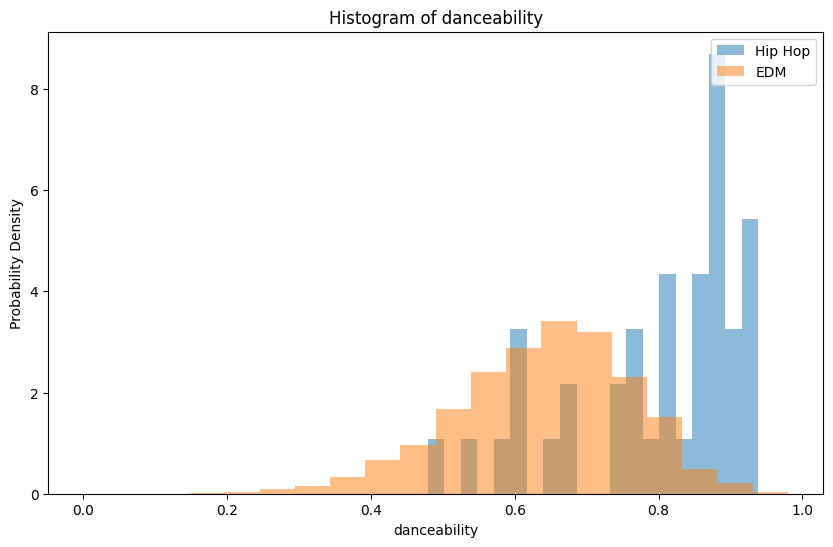

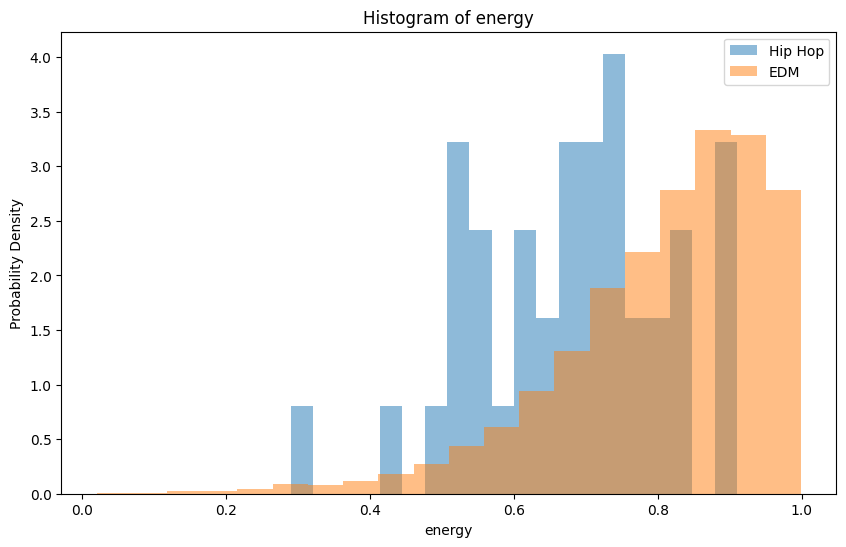

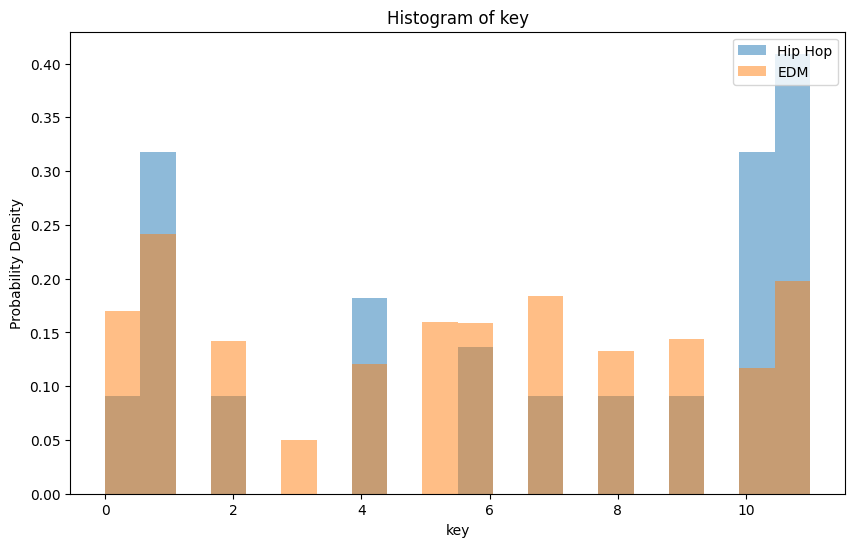

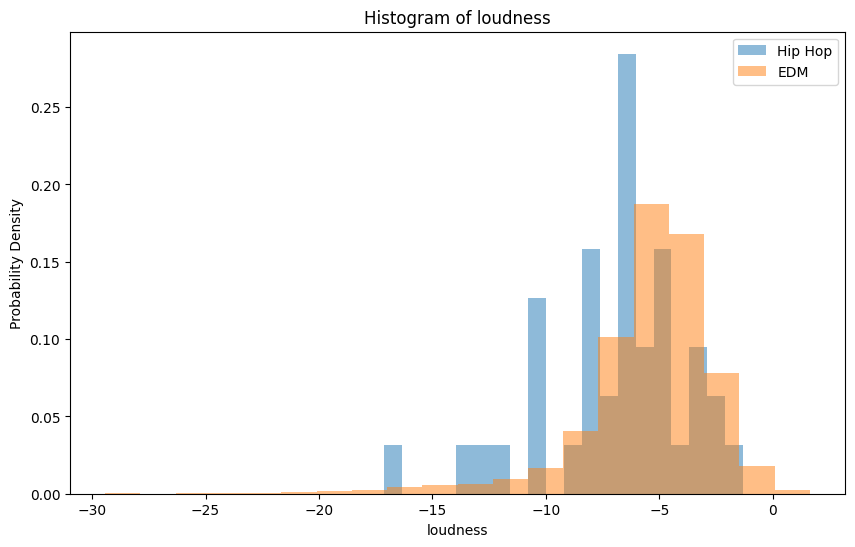

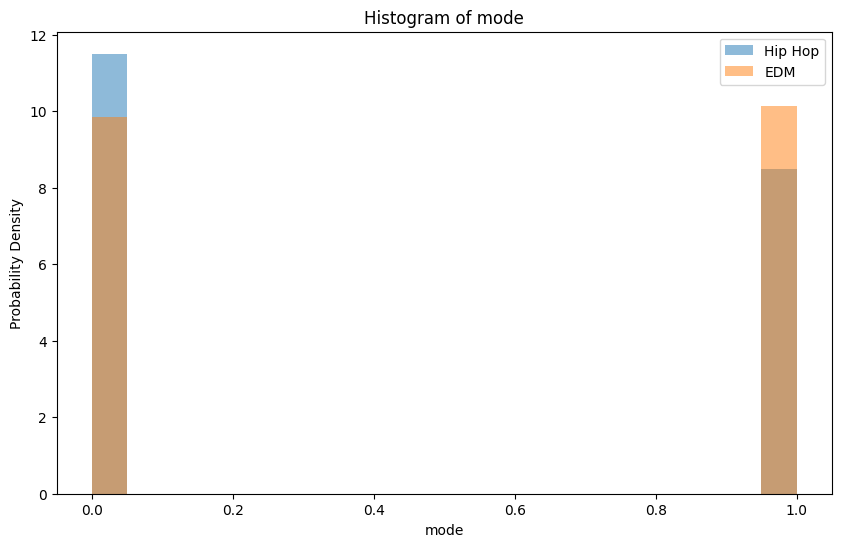

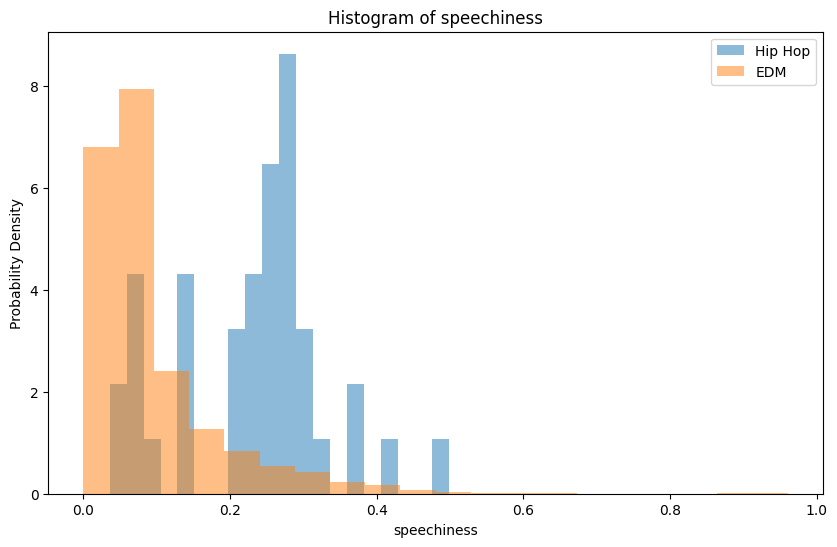

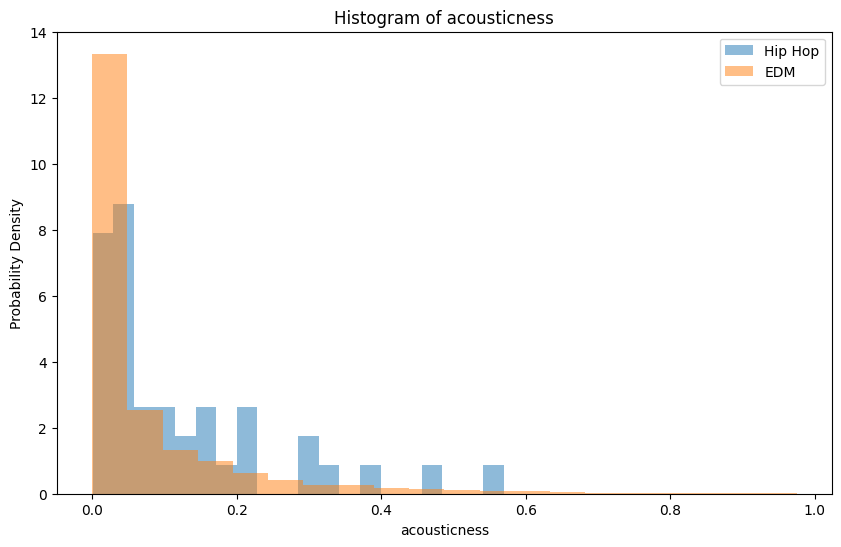

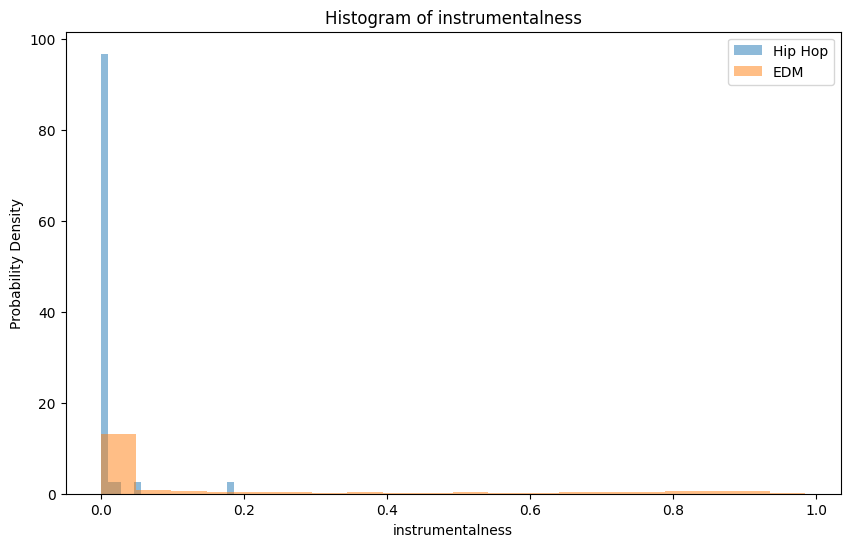

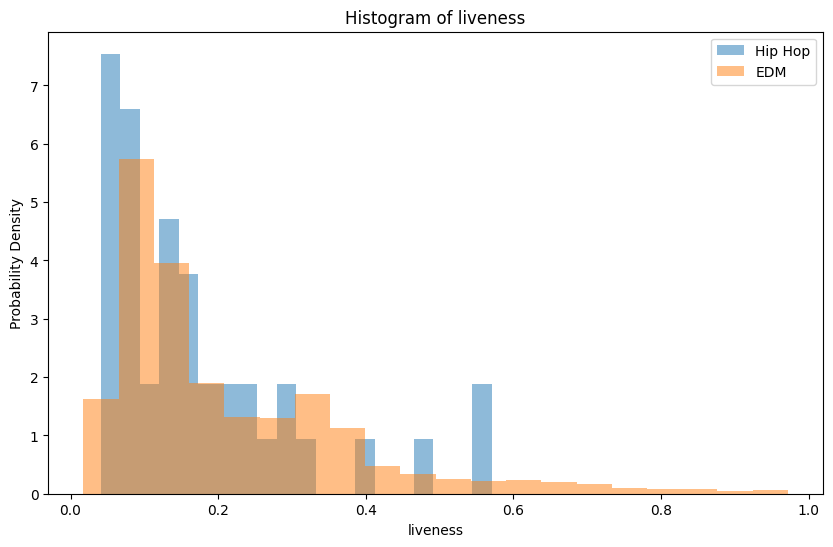

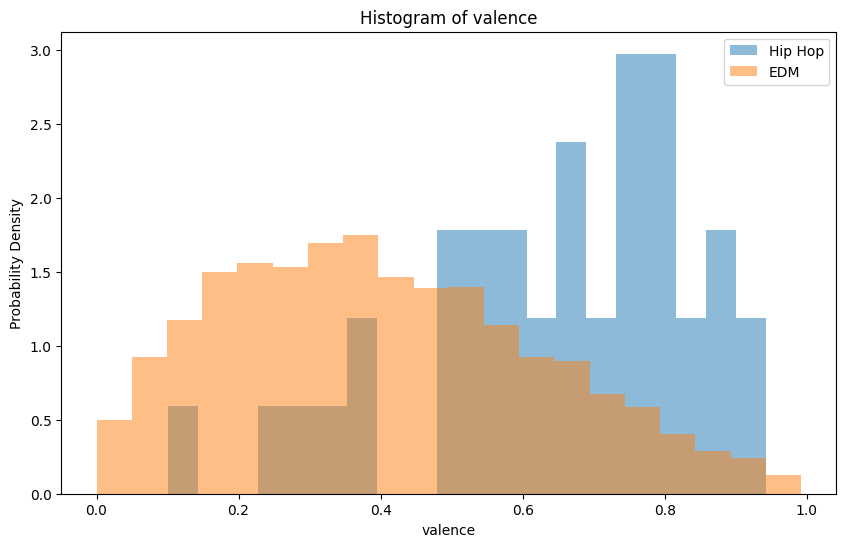

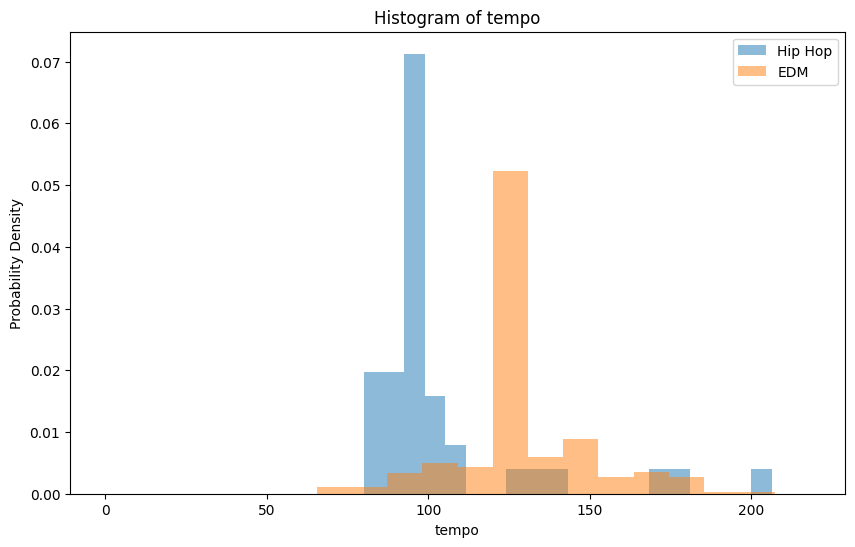

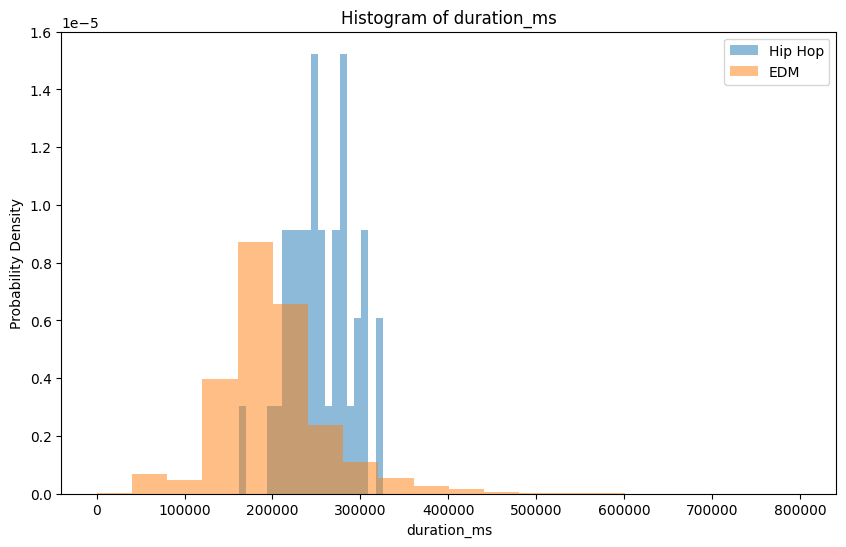

In [ ]:
# Plot histogram comparing audio features for both playlist genres

audio_features = ['danceability','energy','key','loudness','mode',
                  'speechiness','acousticness','instrumentalness',
                  'liveness','valence','tempo','duration_ms']

# Loop through each feature to create a histogram
for feature in audio_features:
    plt.figure(figsize=(10, 6))

    plt.hist(hip_hop_df[feature], density=True, alpha=0.5, label='Hip Hop', bins=20)
    plt.hist(edm_df[feature], density=True, alpha=0.5, label='EDM', bins=20)

    plt.title(f'Histogram of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Probability Density')
    plt.legend(loc='upper right')

    plt.show()

>Q: What audio feature/s best defines the genre you picked? Does it make sense to use these as a feature for a classification model?

Answer here